<a href="https://colab.research.google.com/github/joshuaghannan/ECEC247_Project/blob/jgh_tests/Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Run:
### 1. Run all cells with functions/classes/definitions

### 2. Run the last three cells (where you can specifiy the data split, data augmentation type (still in progress), the model, and the training)

TODO: 

1. Add functionality for data augmentation methods 2-4
2. Fix the training/validation split method so that it:

    -> keeps track of person ID

    -> rotates which fold is the validation set (and doesn't do data augmentation on this set)

3. Make the RNN models parameterizable (number of layers, density, dropout, activation function, regularization, density, etc.)

4. Implement a grid seach/Panda df to easily store all results

## Load npy datasets

In [1]:
########################################################

# If running with Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
########################################################

# If running with Google Colab
# Create a folder "C247" and then store the project datasets within that folder
# Check that your datasets are setup correctly

!ls "/content/gdrive/My Drive/C247" # File path

EEG_loading.ipynb	PyTorch_Experiments.ipynb  y_test.npy
person_test.npy		X_test.npy		   y_train_valid.npy
person_train_valid.npy	X_train_valid.npy


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [0]:
import torch
import torch.nn as nn

### Setting Up the Device

In [5]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Load the Datasets

In [0]:
# X_test = np.load("X_test.npy")
# y_test = np.load("y_test.npy")
# person_train_valid = np.load("person_train_valid.npy")
# X_train_valid = np.load("X_train_valid.npy")
# y_train_valid = np.load("y_train_valid.npy")
# person_test = np.load("person_test.npy")

# Change if your directory is different
dataset_path = "/content/gdrive/My Drive/C247/" 

X_test = np.load(dataset_path + "X_test.npy")
y_test = np.load(dataset_path + "y_test.npy")
person_train_valid = np.load(dataset_path + "person_train_valid.npy")
X_train_valid = np.load(dataset_path + "X_train_valid.npy")
y_train_valid = np.load(dataset_path + "y_train_valid.npy")
person_test = np.load(dataset_path + "person_test.npy")

### Shape of the Data

In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Split the data into Train and Validation Function
TODO: Determine how to do this so that only the train (not val) data goes through the data augmentation

In [0]:
def Train_Val_Data(X_train_valid, y_train_valid, split=0.8):
  '''
  Funcion to split the data into train and validation data sets
  input: X_train_valid, y_train_valid, split (percentage of data that's trianing)
  output: Xtrain, ytrain, Xval, yval

  TODO: Fix this to do real k-fold CV ... 
  '''
  perm = np.random.permutation(X_train_valid.shape[0]) # Shuffle Indices
  numTrain = int(split*X_train_valid.shape[0]) # Get the split
  numVal = X_train_valid.shape[0] - numTrain
  # Xtrain = torch.FloatTensor(X_train_valid[perm[0:numTrain]].transpose(0, 2, 1))
  Xtrain = torch.FloatTensor(X_train_valid[perm[0:numTrain]])
  ytrain = torch.LongTensor(y_train_valid[perm[0:numTrain]])

  # Xval = torch.FloatTensor(X_train_valid[perm[numTrain:]].transpose(0, 2, 1))
  Xval = torch.FloatTensor(X_train_valid[perm[numTrain:]])
  yval = torch.LongTensor(y_train_valid[perm[numTrain:]])

  return Xtrain, ytrain, Xval, yval

# # Something like this should be better... 
# from random import randrange
 
# # Split a dataset into k folds
# def cross_validation_split(dataset, folds=3):
# 	dataset_split = list()
# 	dataset_copy = list(dataset)
# 	fold_size = int(len(dataset) / folds)
# 	for i in range(folds):
# 		fold = list()
# 		while len(fold) < fold_size:
# 			index = randrange(len(dataset_copy))
# 			fold.append(dataset_copy.pop(index))
# 		dataset_split.append(fold)
# 	return dataset_split

### Data loader function

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
y_train_valid -= 769
y_test -= 769

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

### Data Split and Augmentation Function

In [0]:
def Split_and_Aug_Data(X_train_valid, y_train_valid, batch_size=128, 
                          split=0.8, aug_type=None, 
                          window_size=200, stride=100):
  
    '''
    Performs training/validation split on data, then performs window data 
    augmentation.

    inputs: X_train_valid, y_train_valid, batch_size, split, aug_type,
             window_size, stride

             -> aug_type = None, "window", "stft", "dwt", "cwt"

    outputs: Xtrain, ytrain, Xval, yval, loader

    TODO: 
    1. Make it work for all different types of data augmentation
        -> need to convert outputs from data augmentations 2-4 into usable types
        -> allow it to take in params argument that has different specs for the
            data augmentation types, instead of hardcoding it for windowing
    2. Fix the training/validation split

    '''

    # split the dataset into train and val
    # call train_val_data function
    X_train, y_train, Xval, yval = Train_Val_Data(X_train_valid, y_train_valid, split=split)

    # No data augmentation
    if aug_type == None:
      Xtrain, ytrain = X_train, y_train

    # Perform Windowing Data Augmentation
    elif aug_type == "window":
      _, Xtrain, ytrain = window_data(X_train, y_train, window_size=window_size, stride=stride)

    # TODO: Set up for data augmentations 2-4, including the input params and the output dimensions/types
    # Perform STFT
    elif aug_type == "stft":
      print('Warning: Need to setup')

    # Perform DWT 
    elif aug_type == "dwt":
      Xtrain = dwt_data(X_train_valid,'sym9')
      ytrain = y_train
      print('Warning: Need to setup')

    # Perform CWT
    elif aug_type == "cwt":
      print('Warning: Need to setup')

    # Fix ordering, change to torch variable
    if aug_type == None:
      Xtrain = Xtrain.permute(0,2,1)
    else:
      Xtrain = torch.FloatTensor(Xtrain.transpose(0, 2, 1))
      ytrain = torch.LongTensor(ytrain)
    Xval = Xval.permute(0, 2, 1)

    # Use dataloader for NN
    batch_size = batch_size
    dataset = Dataset(Xtrain, ytrain)
    loader = DataLoader(dataset, batch_size)

    return Xtrain, ytrain, Xval, yval, loader

## Data Augmentation Functions

### 1. Window Data

In [0]:
def window_data(X, y, window_size, stride):
  '''
  This function takes in X (a 3-d tensor) of size (#trials x #electrodes x #time 
  series) and y data of size (#trials) and outputs two options for using it. 
  X_new1: The first output stacks the windowed data in a new dimension, resulting 
    in a 4-d tensor of size (#trials x #electrodes x #windows x #window_size).
  X_new2: The second option makes the windows into new trails, resulting in a new
    X tensor of size (#trials*#windows x #electrodes x #window_size). To account 
    for the larger number of trials, we also need to augment the y data.
  y_new:  The augmented y vector of size (#trials*#windows) to match X_new2.
 
  Some code to visualize what's happening:
  X_new_wind1, X_new_wind2, Y_new  = window_data(X_train_valid, y_train_valid, 200, 20)
  print(X_new_wind1.shape)
  print(X_new_wind2.shape)
  print(Y_new.shape)

  # Example use case
  _, X_train, y_train = window_data(X_train_valid, y_train_valid, window_size=200, stride=10)
  '''
  num_sub_trials = int((X.shape[2]-window_size)/stride)
  X_new1 = np.empty([X.shape[0],X.shape[1],num_sub_trials,window_size])
  X_new2 = np.empty([X.shape[0]*num_sub_trials,X.shape[1],window_size])
  y_new = np.empty([X.shape[0]*num_sub_trials])
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      for k in range(num_sub_trials):
        X_new1[i,j,k:k+window_size]    = X[i,j,k*stride:k*stride+window_size]
        X_new2[i*num_sub_trials+k,j,:] = X[i,j,k*stride:k*stride+window_size]
        y_new[i*num_sub_trials+k] = y[i]
  return X_new1, X_new2, y_new

### 2. Short-time Fourier Transform Function

In [0]:
import scipy.signal as sig
import numpy as np

# Function that computes the short-time fourier transform of the data and returns the spectrogram
def spectrogram_data(X,window,stride):
    '''
    Inputs:
    X - input data, last dimension is one which transform will be taken across.
    window - size of sliding window to take transform across
    stride - stride of sliding window across time-series

    Returns:
    X_STFT - Output data, same shape as input with last dimension replaced with two new dimensions, F x T.
            where F = window//2 + 1 is the frequency axis
            and T = (input_length - window)//stride + 1, similar to the formula for aconvolutional filter.
    t - the corresponding times for the time axis, T
    f - the corresponding frequencies on the frequency axis, F.

    Note that a smaller window means only higher frequencies may be found, but give finer time resolution.
    Conversely, a large window gives better frequency resolution, but poor time resolution.

    # EXAMPLE USE CASE:
    Convert only one trial's data to a 2D spectrogram input.
    Use a window of size 100, stride of size 5.
    Input is X_train_valid[1,:,:] of dimensions 1 x 22 x 1000
    output x_spect be 1 x 22 x (1000-100)/5 + 1 x 100 // 2.

    window = 100
    stride = 5
    print('Input dimensions: {}'.format(X_train_valid[0,:,:].shape))

    X_spect, t, f = spectrogram_data(X_train_valid[0,:,:],window=window,stride=stride)

    print('Expected output dimensions: {}'.format((22,window//2+1,(1000-window)//stride+1)))
    print('Acutal output dimensions: {}'.format(X_spect.shape))
    '''
    noverlap = window-stride
    print(noverlap)
    if noverlap < 0 :
        print('Stride results in skipped data!')
        return
    f, t, X_STFT = sig.spectrogram(X,nperseg=window,noverlap=noverlap,fs=250, return_onesided=True)
    return (X_STFT, t, f)

### 3. DWT Function

In [0]:
import pywt
import numpy as np

# FUNCTION TO COMPUTE THE DWT OF DATA
def dwt_data(X,wav_name):
    '''
    Goes along the last axis of the input data (assuming it is N x C x T)
    Computes the DWT coefficients, and takes these as new features
    Returns new array that is N x C x D,
    where D is the number of DWT coefficients.
    Automatically computes to maximum "useful" depth, uses zero padding
    Takes as input a string describing wavelet
    One that was noted as useful before was 'sym9', or the 9th derivative of the symlet wavelet

    # EXAMPLE USE CASE (on training data)

    print('Initial dimensions: {}'.format(X_train_valid.shape))
    X_DWT = dwt_data(X_train_valid,'sym9')
    print('Output dimensions: {}'.format(X_DWT.shape))
    '''
    wav = pywt.Wavelet(wav_name)
    n = X.shape[-1] #extract length of timeseries
    max_level = pywt.dwt_max_level(n,wav)
    out1 = np.concatenate(pywt.wavedec(X[0,:,:],wav,level=max_level,mode='zero'),axis=1)
    out = np.empty((X.shape[0],X.shape[1],out1.shape[1]))
    out[0,:,:] = out1
    for i in range(1,X.shape[0]):
        out[i,:,:] = np.concatenate(pywt.wavedec(X[i,:,:],wav,level=max_level,mode='zero'),axis=1)
    return out

### 4. CWT Function

In [0]:
import scipy.signal as sig
import numpy as np
import pywt

# FUNCTION TO COMPUTE CWT OF DATA
def cwt_data(X,num_levels,top_scale=3):
    '''
    Takes in data, computes CWT using the mexican hat or ricker wavelet using scipy
    Also takes in the top scale parameter.  I use logspace, so scale goes from 1 -> 2^top_scale with num_levels steps.
    Appends to the data a new dimension, of size 'num_levels'
    New dimension corresponds to wavelet content at num_levels different scalings (linear)
    also returns the central frequencies that the scalings correspond to
    input data is N x C X T
    output data is N x C x T x F
    note: CWT is fairly slow to compute

    # EXAMPLE USAGE
    test, freqs = cwt_data(X_train_valid[0:5,:,:],num_levels=75,top_scale=4)
    '''
    scales = np.logspace(start=0,stop=top_scale,num=num_levels)
    out = np.empty((X.shape[0],X.shape[1],X.shape[2],num_levels))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            coef = sig.cwt(X[i,j,:],sig.ricker,scales)
            #out[i,j,:] = np.swapaxes((np.squeeze(coef)),0,1)
            out[i,j,:] = coef.T
    freqs = pywt.scale2frequency('mexh',scales)*250
    return out,freqs

### Define Basic LSTM

In [0]:
class LSTMnet(nn.Module):
    '''
    Create Basic LSTM:
    2 layers

    TODO: make number of layers, dropout, activation function, regularization all params
    see ex: https://blog.floydhub.com/gru-with-pytorch/
    '''

    def __init__(self, input_size, hidden_size, output_dim):
        super(LSTMnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        # self.num_layers = num_layers
        # self.droput = dropout
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                           num_layers=2, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.fc(out[:, -1, :])
        return out

### Define Basic GRU

In [0]:
class GRUnet(nn.Module):
    '''
    Create Basic GRU:
    2 layers

    TODO: make number of layers, dropout, activation function, regularization all params
    see ex: https://blog.floydhub.com/gru-with-pytorch/
    '''

    def __init__(self, input_size, hidden_size, output_dim):
        super(GRUnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        # self.num_layers = num_layers
        # self.droput = dropout
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                           num_layers=2, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.fc(out[:, -1, :])
        return out

### RNN Initialization Function

In [0]:
def InitRNN(rnn_type="LSTM", input_size=22, hidden_size=20, output_dim=4):
    '''
    Function to initialize RNN
    
    input: RNN type(LSTM, GRU), and other params if neccessary (regularization, acitvation, dropout, num layers, etc.)

    output: model, criterion, optimizer

    TODO: Eventually should also take in params such as dropout, number of layers, and activation function(s), etc.
    '''

    if rnn_type=="LSTM":
        model = LSTMnet(input_size=input_size, hidden_size=hidden_size, output_dim=output_dim).to(device)

    elif rnn_type=="GRU":
        model = GRUnet(input_size=input_size, hidden_size=hidden_size, output_dim=output_dim).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    return model, criterion, optimizer



### NN Train Function

In [0]:
def TrainRNN(num_epochs=20, verbose=True):
  
    '''
    Function that trains the NN

    input: num_epochs
    
    output: nothing; just prints the statistics
    '''
  
    print("Firing Up the ol' computer ...")
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    epoch = 0

    # TODO: 
    # 1. Change the dimensions of the data using .transpose(0, 2, 1)
    # 2. Create for loop to iterate over the number of folds

    t0 = time.time()
    num_epochs = num_epochs
    for ep in range(num_epochs):
        tstart = time.time()
        for i, data in enumerate(loader):
            optimizer.zero_grad()
            outputs = model(data[0].to(device))
            loss = criterion(outputs, data[1].to(device))
            loss.backward()
            optimizer.step()
        pXtrain = model(Xtrain.to(device))
        ptrain = torch.argmax(pXtrain, axis = 1)
        train_acc = np.mean(ptrain.cpu().numpy() == ytrain.numpy())
        train_accs.append(train_acc)
        tloss = criterion(pXtrain, ytrain.to(device))
        train_losses.append(tloss.item())
        
        pXval = model(Xval.to(device))
        pval = torch.argmax(pXval, axis = 1)
        val_acc = np.mean(pval.cpu().numpy() == yval.numpy())
        val_accs.append(val_acc)
        vloss = criterion(pXval, yval.to(device))
        val_losses.append(vloss.item())
        epoch += 1    
        tend = time.time()
        if verbose:
          print('epoch: {:<3d}    time: {:<3.2f}    loss: {:<3.3f}    train acc: {:<1.3f}    val acc: {:<1.3f}'.format(epoch, 
                tend - tstart, tloss.item(), train_acc, val_acc))
    time_total = time.time() - t0
    print('-----')
    print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

    # Plot stuff...
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title('training and validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])
    plt.subplot(1, 2, 2)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('loss history')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])

    # Get accuracies
    print('-----')
    print('Val Accuracy: {:.4f}'.format(val_accs[-1]))

    # Get Testing Accuracies
    batch_size = 128
    test_dataset = Dataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size)

    total = 0
    correct = 0
    for i, data in enumerate(test_loader):
        eeg_seq = torch.FloatTensor(X_test.transpose(0, 2, 1)).to(device)
        label = torch.LongTensor(y_test).to(device)
        output = model(eeg_seq)
        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == label).item()
        total += label.shape[0]
    print('-----')
    print ('Testing Accuracy: {:.4f}'.format(correct/total))
    print('-----')


## Run Experiments
### 1. Split Data, Perform Data Augmentation
### 2. Define the Model
### 3. Train the Model

### 1. Split Data into Training and Validation, Perform Data Augmentation on Training Set

In [0]:
Xtrain, ytrain, Xval, yval, loader = Split_and_Aug_Data(X_train_valid, 
                                                          y_train_valid, 
                                                          batch_size=128, 
                                                          split=0.8, 
                                                          aug_type="window",
                                                          window_size=200,
                                                          stride=200)

# Test the split/aug data function
# print(Xtrain.shape, Xval.shape)

# for i, data in enumerate(loader):
#     print(data[0].to(device).shape, data[1].to(device).shape)
#     break

### 2. Define the Model

In [0]:
model, criterion, optimizer = InitRNN(rnn_type='LSTM')

### 3. Train the NN

Firing Up the ol' computer ...
epoch: 1      time: 3.40    loss: 1.384    train acc: 0.265    val acc: 0.234
epoch: 2      time: 3.13    loss: 1.382    train acc: 0.283    val acc: 0.227
epoch: 3      time: 3.00    loss: 1.379    train acc: 0.290    val acc: 0.241
epoch: 4      time: 2.90    loss: 1.377    train acc: 0.302    val acc: 0.270
epoch: 5      time: 2.85    loss: 1.374    train acc: 0.310    val acc: 0.270
epoch: 6      time: 2.68    loss: 1.372    train acc: 0.304    val acc: 0.236
epoch: 7      time: 2.68    loss: 1.370    train acc: 0.310    val acc: 0.248
epoch: 8      time: 2.67    loss: 1.365    train acc: 0.312    val acc: 0.243
epoch: 9      time: 2.69    loss: 1.362    train acc: 0.321    val acc: 0.236
epoch: 10     time: 2.63    loss: 1.356    train acc: 0.323    val acc: 0.234
epoch: 11     time: 2.69    loss: 1.351    train acc: 0.342    val acc: 0.241
epoch: 12     time: 2.67    loss: 1.345    train acc: 0.339    val acc: 0.260
epoch: 13     time: 2.65    loss:

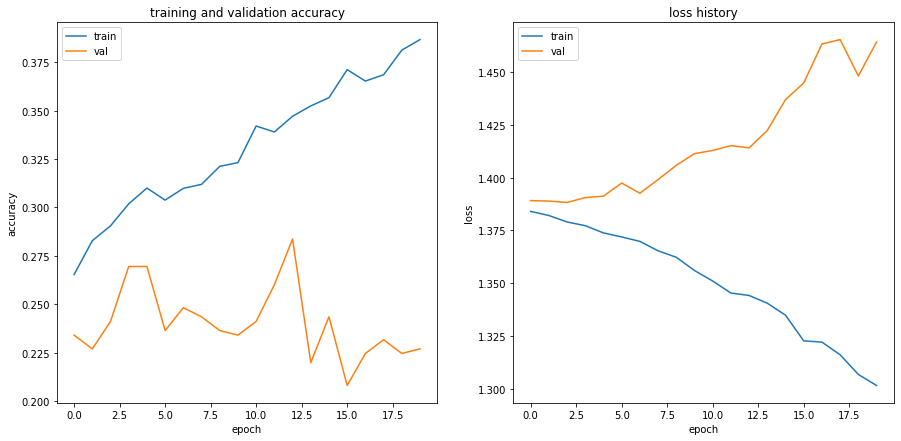

In [22]:
TrainRNN(num_epochs=20)